# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from lightgbm import early_stopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


device = torch.device("mps" if torch.backends.mps.is_available() 
                      else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

Using device: mps


# Loading Dataset

In [2]:
train_data_full = pd.read_excel(
    "archive/train_dataframes.xlsx",
    sheet_name=0,
    parse_dates=['datetime'],
    index_col='datetime'
)
test_data = pd.read_excel(
    "archive/test_dataframes.xlsx",
    sheet_name=0,
    parse_dates=['datetime'],
    index_col='datetime'
)

val_ratio = 0.2
val_size = int(len(train_data_full) * val_ratio)

val_data = train_data_full.iloc[-val_size:].copy()
train_data = train_data_full.iloc[:-val_size].copy()

print("Train shape:", train_data.shape)
print("Val shape:",   val_data.shape)
print("Test shape:",  test_data.shape)



Train shape: (29376, 11)
Val shape: (7344, 11)
Test shape: (168, 11)


In [3]:
train_data_full.head()

,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


*   The datetime column is parsed as a date/time index, so we can do time series operations easily.

# Cycle Encoding

In [4]:


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cyclical_encoding_hour(df, hour_col='hour'):
    df['hour_sin'] = np.sin(2 * np.pi * df[hour_col] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df[hour_col] / 24)
    return df

def cyclical_encoding_dayofweek(df, dow_col='dayofweek'):
    df['dow_sin'] = np.sin(2 * np.pi * df[dow_col] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df[dow_col] / 7)
    return df

for df_ in [train_data, val_data, test_data]:
    df_['hour'] = df_.index.hour
    df_['dayofweek'] = df_.index.dayofweek
    df_ = cyclical_encoding_hour(df_, 'hour')
    df_ = cyclical_encoding_dayofweek(df_, 'dayofweek')


*   Defines a custom Mean Absolute Percentage Error (MAPE) function to handle cases where the true values could be zero.
*   Defines functions to apply cyclical feature encoding for hour-of-day and day-of-week.
*   This helps the model understand that after 23:00 it cycles back to 00:00, and similarly for days of the week.
*   Adds hour and dayofweek columns derived from the datetime index.
*   Applies the cyclical encoding to each of these columns.

# Fetures

In [5]:
features = [
    'week_X-2','week_X-3','week_X-4','MA_X-4',
    'dayOfWeek','weekend','holiday','Holiday_ID',
    'hourOfDay','T2M_toc',
    'hour_sin','hour_cos','dow_sin','dow_cos'
]
# Ensure 'DEMAND' is appended last:
all_features = features + ['DEMAND']

#  MinMax Scaler

In [6]:
combined = pd.concat([train_data, val_data], axis=0)
scaler = MinMaxScaler()
combined_scaled = scaler.fit_transform(combined[all_features])

train_scaled = combined_scaled[: len(train_data)]
val_scaled   = combined_scaled[len(train_data) : (len(train_data)+len(val_data))]
test_scaled  = scaler.transform(test_data[all_features])

*   Concatenates train and validation data so the scaler can see the full range of those sets.
*   Fits a MinMaxScaler on this combined data and then transforms them.
*   Scales the test set with the same scaler so that features and target are consistently scaled.

# Pytorch LSTM

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the best configuration settings
config = {
    'seq_len': 24,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 50
}

# 1. Create sequences
def create_sequences_torch(data, seq_length):
    Xs, ys = [], []
    n_features = data.shape[1] - 1  # all columns except last are features
    for i in range(len(data) - seq_length):
        Xs.append(data[i : i + seq_length, :n_features])
        ys.append(data[i + seq_length, -1])  # last column is the target
    return np.array(Xs), np.array(ys)

# Apply sequence length from config
X_train_pt, y_train_pt = create_sequences_torch(train_scaled, config['seq_len'])
X_val_pt,   y_val_pt   = create_sequences_torch(val_scaled,   config['seq_len'])
X_test_pt,  y_test_pt  = create_sequences_torch(test_scaled,  config['seq_len'])

# 2. Convert to PyTorch Tensors and create Datasets
train_ds = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train_pt),
    torch.FloatTensor(y_train_pt).unsqueeze(-1)
)
val_ds = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_val_pt),
    torch.FloatTensor(y_val_pt).unsqueeze(-1)
)
test_ds = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_test_pt),
    torch.FloatTensor(y_test_pt).unsqueeze(-1)
)

# 3. Create DataLoaders with batch size from config
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=config['batch_size'], shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=config['batch_size'], shuffle=False)

# 4. Define the LSTM Model with parameters from config
class DemandLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(DemandLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,  # Dropout only applied if num_layers > 1
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

# 5. Training and Evaluation Functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_list, trues_list = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, yb)
            running_loss += loss.item() * Xb.size(0)
            preds_list.append(pred.cpu().numpy())
            trues_list.append(yb.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    preds = np.vstack(preds_list)
    trues = np.vstack(trues_list)
    rmse = math.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    return avg_loss, rmse, mae, preds, trues

# 6. Initialize Model, Optimizer, and Loss Function
input_size_pt = len(features)  # number of features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is correctly set

model_pt = DemandLSTM(
    input_size=input_size_pt,
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
).to(device)

optimizer_pt = optim.Adam(model_pt.parameters(), lr=config['lr'])
criterion_pt = nn.MSELoss()

# 7. Training Loop
for epoch in range(1, config['epochs'] + 1):
    train_loss = train_one_epoch(model_pt, train_loader, criterion_pt, optimizer_pt, device)
    val_loss, val_rmse, val_mae, val_preds, val_trues = evaluate(model_pt, val_loader, criterion_pt, device)
    val_mape = mean_absolute_percentage_error(val_trues, val_preds)
    if epoch == 1 or epoch == config['epochs'] or epoch % 2 == 0:
        print(f"Epoch {epoch}/{config['epochs']} | TrainLoss={train_loss:.4f} "
              f"ValRMSE={val_rmse:.2f} ValMAPE={val_mape:.2f}%")

# 8. Evaluate on Test Set
_, test_rmse_pt, test_mae_pt, test_preds_pt, test_trues_pt = evaluate(model_pt, test_loader, criterion_pt, device)
test_mape_pt = mean_absolute_percentage_error(test_trues_pt, test_preds_pt)
print("\nPyTorch LSTM Test => RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}%".format(
    test_rmse_pt, test_mae_pt, test_mape_pt))

# 9. Inverse Transform Predictions
test_preds_full = np.zeros((len(test_preds_pt), len(all_features)))
test_preds_full[:, -1] = test_preds_pt.ravel()
inv_preds_pt = scaler.inverse_transform(test_preds_full)[:, -1]

test_trues_full = np.zeros((len(test_trues_pt), len(all_features)))
test_trues_full[:, -1] = test_trues_pt.ravel()
inv_trues_pt = scaler.inverse_transform(test_trues_full)[:, -1]

pt_rmse = math.sqrt(mean_squared_error(inv_trues_pt, inv_preds_pt))
pt_mae  = mean_absolute_error(inv_trues_pt, inv_preds_pt)
pt_mape = mean_absolute_percentage_error(inv_trues_pt, inv_preds_pt)
print("PyTorch LSTM (Inverse-Scaled) => RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}%".format(
    pt_rmse, pt_mae, pt_mape))


Epoch 1/50 | TrainLoss=0.0071 ValRMSE=0.05 ValMAPE=389182423040.00%
Epoch 2/50 | TrainLoss=0.0017 ValRMSE=0.04 ValMAPE=395875713024.00%
Epoch 4/50 | TrainLoss=0.0014 ValRMSE=0.04 ValMAPE=394294722560.00%
Epoch 6/50 | TrainLoss=0.0012 ValRMSE=0.04 ValMAPE=398778957824.00%
Epoch 8/50 | TrainLoss=0.0012 ValRMSE=0.03 ValMAPE=408973246464.00%
Epoch 10/50 | TrainLoss=0.0011 ValRMSE=0.04 ValMAPE=404119093248.00%
Epoch 12/50 | TrainLoss=0.0010 ValRMSE=0.03 ValMAPE=394350592000.00%
Epoch 14/50 | TrainLoss=0.0010 ValRMSE=0.04 ValMAPE=409165496320.00%
Epoch 16/50 | TrainLoss=0.0010 ValRMSE=0.04 ValMAPE=400215736320.00%
Epoch 18/50 | TrainLoss=0.0009 ValRMSE=0.04 ValMAPE=397709574144.00%
Epoch 20/50 | TrainLoss=0.0009 ValRMSE=0.03 ValMAPE=402995150848.00%
Epoch 22/50 | TrainLoss=0.0009 ValRMSE=0.03 ValMAPE=405819490304.00%
Epoch 24/50 | TrainLoss=0.0009 ValRMSE=0.03 ValMAPE=416251215872.00%
Epoch 26/50 | TrainLoss=0.0009 ValRMSE=0.03 ValMAPE=407311417344.00%
Epoch 28/50 | TrainLoss=0.0008 ValRMSE=

I used the configurations in the Playground part I have fine tuned the pythorch LSTM (Best Configuration {'seq_len': 24, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001})

The PyTorch LSTM model employs a sequence of LSTM layers capable of capturing long term dependencies within time series data. By passing historical sequences of features through multiple LSTM units, the model learns patterns such as seasonality and trends in the data. The final dense layer outputs a single demand forecast value. This approach benefits from PyTorch’s flexible framework, making customizations (like dropout and multi-layer stacking) straightforward.

# Keras LSTM

In [9]:
def create_sequences_keras(data, seq_length):
    Xs, ys = [], []
    n_feat = data.shape[1] - 1
    for i in range(len(data) - seq_length):
        Xs.append(data[i : i + seq_length, :n_feat])
        ys.append(data[i + seq_length, -1])
    return np.array(Xs), np.array(ys)

# Option B: Use config['seq_len'] directly
X_train_k, Y_train_k = create_sequences_keras(train_scaled, config['seq_len'])
X_val_k,   Y_val_k   = create_sequences_keras(val_scaled,   config['seq_len'])
X_test_k,  Y_test_k  = create_sequences_keras(test_scaled,  config['seq_len'])

print("\nKeras LSTM shapes =>", X_train_k.shape, Y_train_k.shape, X_val_k.shape, Y_val_k.shape, X_test_k.shape, Y_test_k.shape)

def create_keras_model(input_shape):
    model = Sequential()
    model.add(LSTM(200, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(200, activation='tanh', return_sequences=False))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape_k = (X_train_k.shape[1], X_train_k.shape[2])
model_k = create_keras_model(input_shape_k)
model_k.summary()

EPOCHS_K = 50
BATCH_SIZE_K = 72

model_k.fit(
    X_train_k, Y_train_k,
    epochs=EPOCHS_K,
    batch_size=BATCH_SIZE_K,
    validation_data=(X_val_k, Y_val_k),
    verbose=1
)

preds_test_scaled_k = model_k.predict(X_test_k)

# Inverse transform
full_test_array_k = np.zeros((len(preds_test_scaled_k), len(all_features)))
full_test_array_k[:, -1] = preds_test_scaled_k.ravel()
inv_preds_k = scaler.inverse_transform(full_test_array_k)[:, -1]

full_test_y_array_k = np.zeros((len(Y_test_k), len(all_features)))
full_test_y_array_k[:, -1] = Y_test_k.ravel()
inv_trues_k = scaler.inverse_transform(full_test_y_array_k)[:, -1]

k_rmse = math.sqrt(mean_squared_error(inv_trues_k, inv_preds_k))
k_mae  = mean_absolute_error(inv_trues_k, inv_preds_k)
k_mape = mean_absolute_percentage_error(inv_trues_k, inv_preds_k)
print("\nKeras LSTM (Inverse-Scaled) => RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}%".format(
    k_rmse, k_mae, k_mape))



Keras LSTM shapes => (29352, 24, 14) (29352,) (7320, 24, 14) (7320,) (144, 24, 14) (144,)


2025-01-28 20:57:59.487502: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-01-28 20:57:59.487539: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-28 20:57:59.487543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-28 20:57:59.487559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-28 20:57:59.487570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 200)        │       172,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,901 (1.92 MB)

 Trainable params: 502,901 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-28 20:57:59.942619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0212 - val_loss: 0.0025
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0023 - val_loss: 0.0110
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 11/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 12/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/st

Similar in design to its PyTorch counterpart, the Keras LSTM model leverages recurrent layers to capture sequential information. Keras offers a more high-level interface and simplified syntax, which can be advantageous for rapid experimentation. However, performance differences can arise from differing hyperparameters, optimizers, or even the specific initialization schemes used.

# Linear Regression

In [10]:
# We flatten the scaled data (but skip the last col for X, last col is DEMAND)
n_feat = len(features)  # number of feature columns
X_train_val  = train_scaled[:, :n_feat]
X_val2       = val_scaled[:,   :n_feat]
X_test_sklearn = test_scaled[:, :n_feat]
y_train_val  = train_scaled[:, -1]
y_val2       = val_scaled[:,   -1]
y_test_sklearn = test_scaled[:, -1]

# 7.1) Fit LR on (train+val) scaled
lr_model = LinearRegression()
X_train_val_combined = np.vstack((X_train_val, X_val2))
y_train_val_combined = np.hstack((y_train_val, y_val2))
lr_model.fit(X_train_val_combined, y_train_val_combined)
lr_preds_scaled = lr_model.predict(X_test_sklearn)

# Inverse
temp_lr = np.zeros((len(lr_preds_scaled), len(all_features)))
temp_lr[:, -1] = lr_preds_scaled
lr_preds_inv = scaler.inverse_transform(temp_lr)[:,-1]

# Similarly for the actual
temp_ytest = np.zeros((len(y_test_sklearn), len(all_features)))
temp_ytest[:,-1] = y_test_sklearn
y_test_inv = scaler.inverse_transform(temp_ytest)[:,-1]

lr_rmse = math.sqrt(mean_squared_error(y_test_inv, lr_preds_inv))
lr_mae  = mean_absolute_error(y_test_inv, lr_preds_inv)
lr_mape = mean_absolute_percentage_error(y_test_inv, lr_preds_inv)
print("\nLinearRegression => RMSE: %.2f, MAE: %.2f, MAPE: %.2f%%" % (lr_rmse, lr_mae, lr_mape))




LinearRegression => RMSE: 100.26, MAE: 58.06, MAPE: 0.05%


A baseline machine-learning approach, Linear Regression finds a linear relationship between features (including time based or lag features) and the target demand. Though quick to train and interpret, its simplicity can miss complex, non linear trends in the data, leading to higher errors when the underlying patterns are non linear or seasonal.

# GradientBoosting

In [11]:
gb_model = GradientBoostingRegressor(
    n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
)
gb_model.fit(X_train_val_combined, y_train_val_combined)
gb_preds_scaled = gb_model.predict(X_test_sklearn)

temp_gb = np.zeros((len(gb_preds_scaled), len(all_features)))
temp_gb[:,-1] = gb_preds_scaled
gb_preds_inv = scaler.inverse_transform(temp_gb)[:,-1]

gb_rmse = math.sqrt(mean_squared_error(y_test_inv, gb_preds_inv))
gb_mae  = mean_absolute_error(y_test_inv, gb_preds_inv)
gb_mape = mean_absolute_percentage_error(y_test_inv, gb_preds_inv)
print("GradientBoost => RMSE: %.2f, MAE: %.2f, MAPE: %.2f%%" % (gb_rmse, gb_mae, gb_mape))

GradientBoost => RMSE: 53.93, MAE: 46.13, MAPE: 0.04%


Gradient Boosting builds an ensemble of decision trees in a stage wise fashion, where each new tree attempts to correct the errors of the previous ensemble. It can capture non-linear relationships more effectively than Linear Regression. By tuning parameters such as the learning rate, maximum depth, and number of estimators, one can strike a balance between model complexity and overfitting risk.

# Arima

In [12]:
train_val_series = pd.concat([train_data['DEMAND'], val_data['DEMAND']])
test_series      = test_data['DEMAND']

arima_model = ARIMA(train_val_series, order=(1,1,1)).fit()
arima_preds = arima_model.forecast(steps=len(test_series))
arima_rmse = math.sqrt(mean_squared_error(test_series, arima_preds))
arima_mae  = mean_absolute_error(test_series, arima_preds)
arima_mape = mean_absolute_percentage_error(test_series.values, arima_preds.values)
print("\nARIMA => RMSE: %.2f, MAE: %.2f, MAPE: %.2f%%" % (arima_rmse, arima_mae, arima_mape))


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



ARIMA => RMSE: 283.74, MAE: 220.31, MAPE: 0.16%


The ARIMA model is a classical statistical approach for time series forecasting, focusing on autocorrelations in the data. It consists of three components—Autoregressive (AR), Integrated (I), and Moving Average (MA) capturing how a current observation relates to its past values and error terms. While ARIMA can be powerful for simpler, non seasonal time series, it may struggle with complex patterns without additional modifications.

# Sarima

In [13]:
sarima_model = SARIMAX(train_val_series, order=(1,1,1), seasonal_order=(1,1,1,24),
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_preds = sarima_model.forecast(steps=len(test_series))
sarima_rmse = math.sqrt(mean_squared_error(test_series, sarima_preds))
sarima_mae  = mean_absolute_error(test_series, sarima_preds)
sarima_mape = mean_absolute_percentage_error(test_series.values, sarima_preds.values)
print("SARIMA => RMSE: %.2f, MAE: %.2f, MAPE: %.2f%%" % (sarima_rmse, sarima_mae, sarima_mape))


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMA => RMSE: 134.56, MAE: 99.70, MAPE: 0.08%


SARIMA extends ARIMA by adding seasonal terms, which allows the model to directly capture repeating seasonal patterns (for example, daily or weekly cycles). It includes additional parameters controlling the seasonal autoregressive and moving average components, making it more suitable for time series with strong cyclical trends. However, manual selection of seasonal orders can become cumbersome for large datasets or more intricate seasonalities.

# LightGBM

In [14]:
X_train_val_lgb = np.vstack((X_train_val, X_val2))
y_train_val_lgb = np.hstack((y_train_val, y_val2))

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)
callbacks = [early_stopping(stopping_rounds=20, verbose=False)]
lgb_model.fit(X_train_val_lgb, y_train_val_lgb,
              eval_set=[(X_val2, y_val2)],
              eval_metric='rmse',
              callbacks=callbacks)
lgb_preds_scaled = lgb_model.predict(X_test_sklearn)

temp_lgb = np.zeros((len(lgb_preds_scaled), len(all_features)))
temp_lgb[:, -1] = lgb_preds_scaled
lgb_preds_inv = scaler.inverse_transform(temp_lgb)[:, -1]

lgb_rmse = math.sqrt(mean_squared_error(y_test_inv, lgb_preds_inv))
lgb_mae  = mean_absolute_error(y_test_inv, lgb_preds_inv)
lgb_mape = mean_absolute_percentage_error(y_test_inv, lgb_preds_inv)
print("\nLightGBM => RMSE: %.2f, MAE: %.2f, MAPE: %.2f%%" % (lgb_rmse, lgb_mae, lgb_mape))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 36720, number of used features: 14
[LightGBM] [Info] Start training from score 0.666556


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM => RMSE: 51.09, MAE: 43.22, MAPE: 0.03%


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM is another tree based ensemble method that uses gradient boosting under the hood, but it implements techniques like leaf wise tree growth for faster training and better memory usage. It can often handle large datasets and high dimensional data efficiently. Like other boosting methods, hyperparameter tuning is essential for optimal performance.

#  Build Final Predictions for Visualization

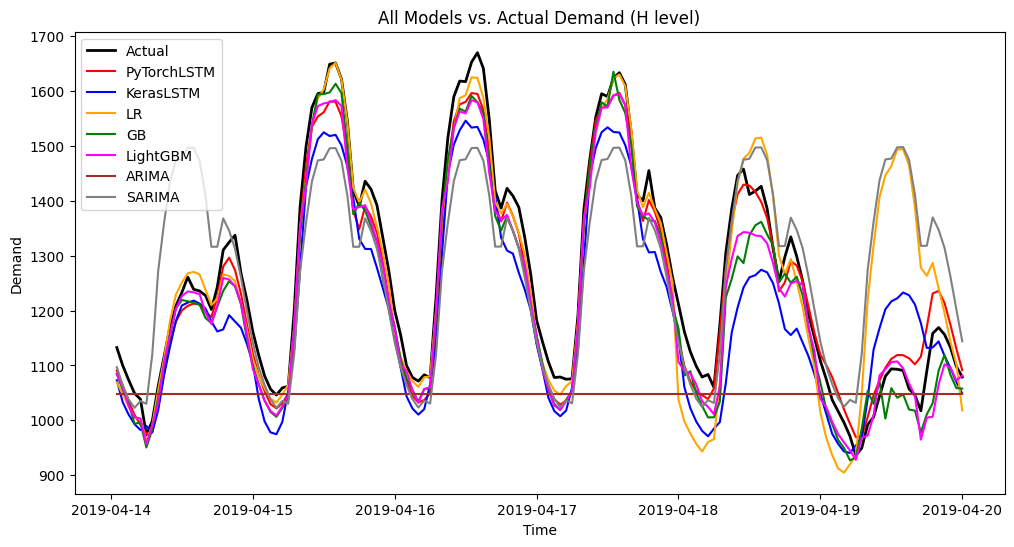

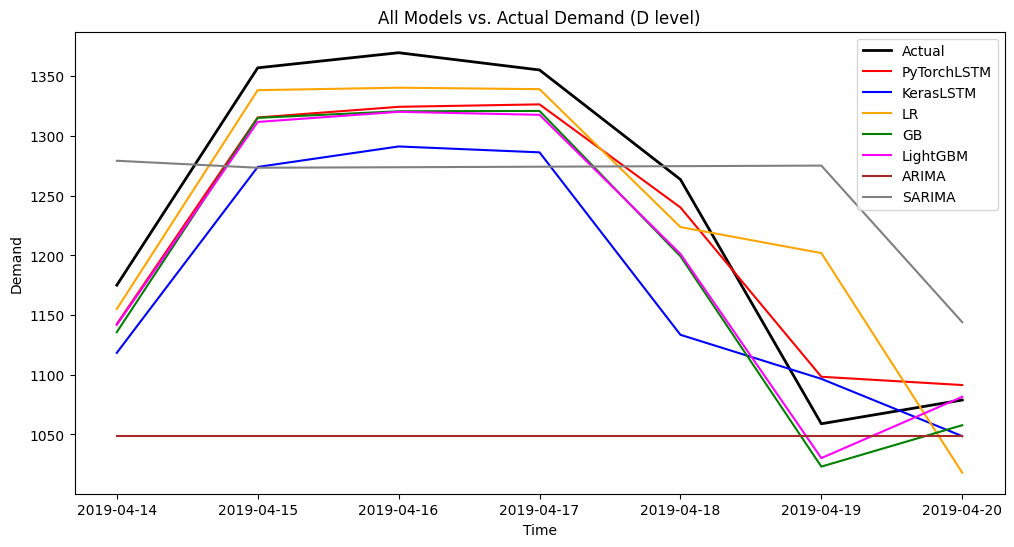

In [15]:

len_pt   = len(inv_preds_pt)    
len_k    = len(inv_preds_k)      
len_lr   = len(lr_preds_inv)
len_gb   = len(gb_preds_inv)
len_lgb  = len(lgb_preds_inv)
len_arima= len(arima_preds)      
len_sarima= len(sarima_preds)

common_length = min(len_pt, len_k, len_lr, len_gb, len_lgb, len_arima, len_sarima)

# Slice each to the last `common_length`
inv_preds_pt     = inv_preds_pt[-common_length:]
inv_preds_k      = inv_preds_k[-common_length:]
lr_preds_inv     = lr_preds_inv[-common_length:]
gb_preds_inv     = gb_preds_inv[-common_length:]
lgb_preds_inv    = lgb_preds_inv[-common_length:]
arima_preds      = arima_preds[-common_length:]
sarima_preds     = sarima_preds[-common_length:]
inv_trues_pt     = inv_trues_pt[-common_length:] 
test_series_sliced = test_series[-common_length:] 

# We'll align to the last `common_length` rows of test_data:
final_index = test_data.index[-common_length:]

big_results = pd.DataFrame(index=final_index)

big_results['True']        = test_series_sliced.values

big_results['PyTorchLSTM'] = inv_preds_pt
big_results['KerasLSTM']   = inv_preds_k
big_results['LR']          = lr_preds_inv
big_results['GB']          = gb_preds_inv
big_results['LightGBM']    = lgb_preds_inv
big_results['ARIMA']       = arima_preds.values
big_results['SARIMA']      = sarima_preds.values

# 11) Quick Plot All Together
def plot_all_models(df, freq='H'):
    if freq.upper() == 'H':
        df_plot = df.copy()
    else:
        df_plot = df.resample(freq).mean()
    plt.figure(figsize=(12,6))
    plt.plot(df_plot.index, df_plot['True'], label='Actual', color='black', linewidth=2)
    model_list = ['PyTorchLSTM','KerasLSTM','LR','GB','LightGBM','ARIMA','SARIMA']
    colors = ['red','blue','orange','green','magenta','brown','gray']
    for m,c in zip(model_list, colors):
        plt.plot(df_plot.index, df_plot[m], label=m, color=c)
    plt.title(f"All Models vs. Actual Demand ({freq} level)")
    plt.xlabel("Time")
    plt.ylabel("Demand")
    plt.legend()
    plt.show()

plot_all_models(big_results, freq='H')
plot_all_models(big_results, freq='D')


# Each Model Plot

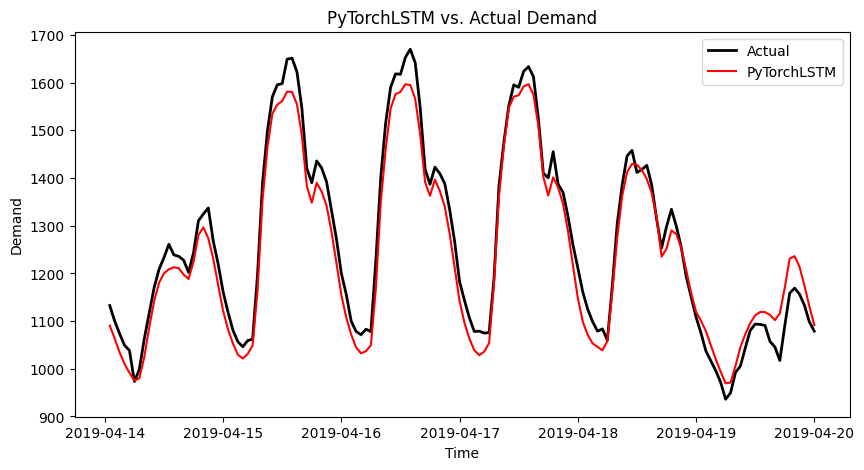

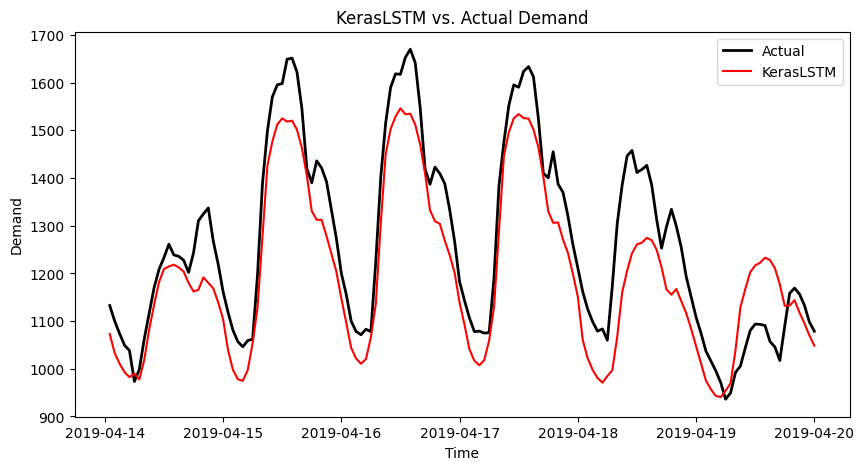

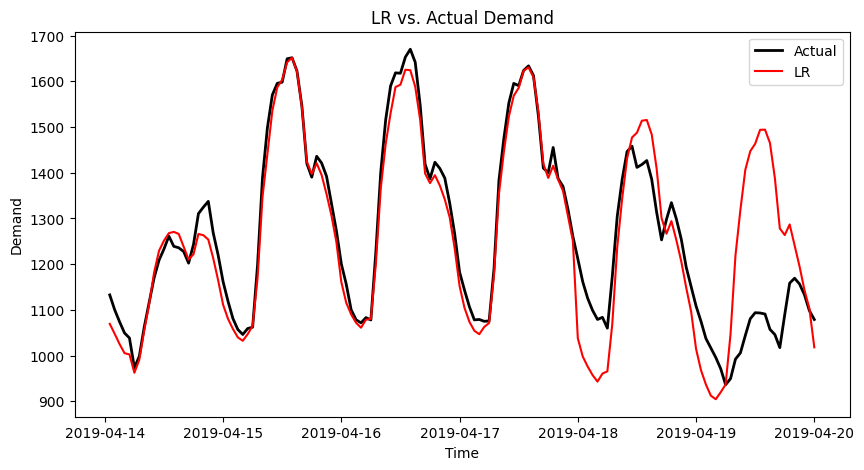

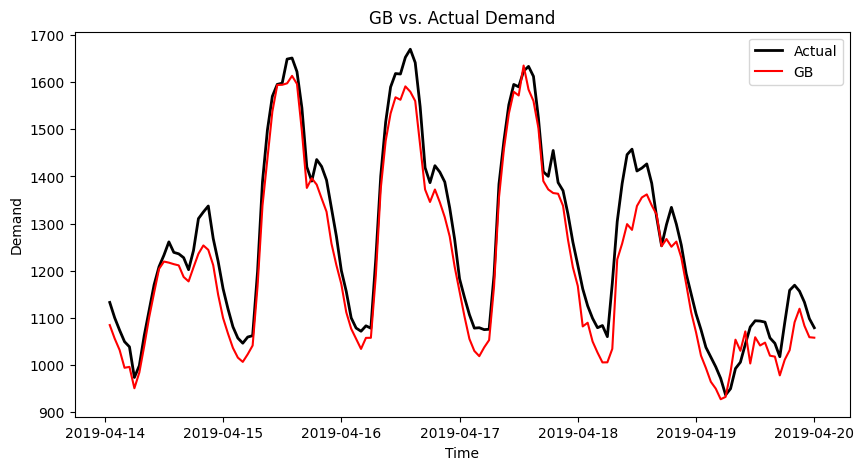

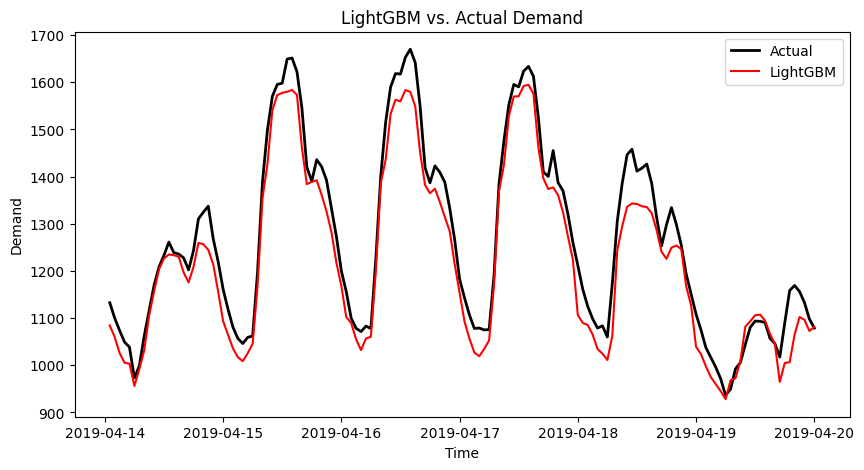

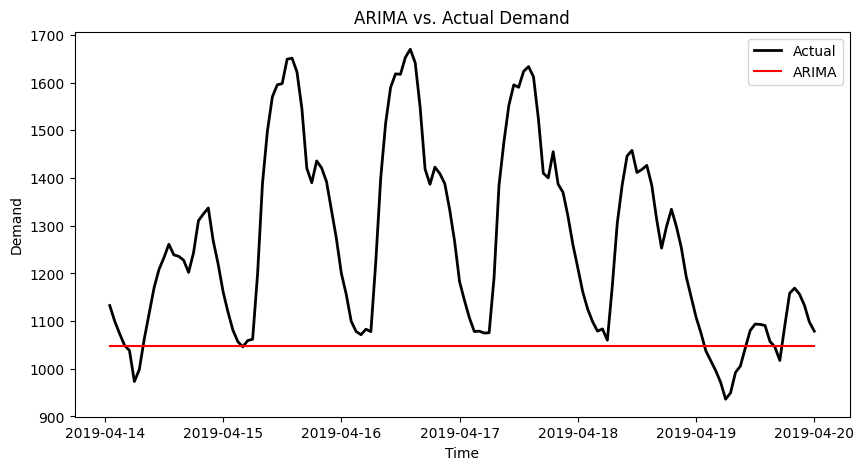

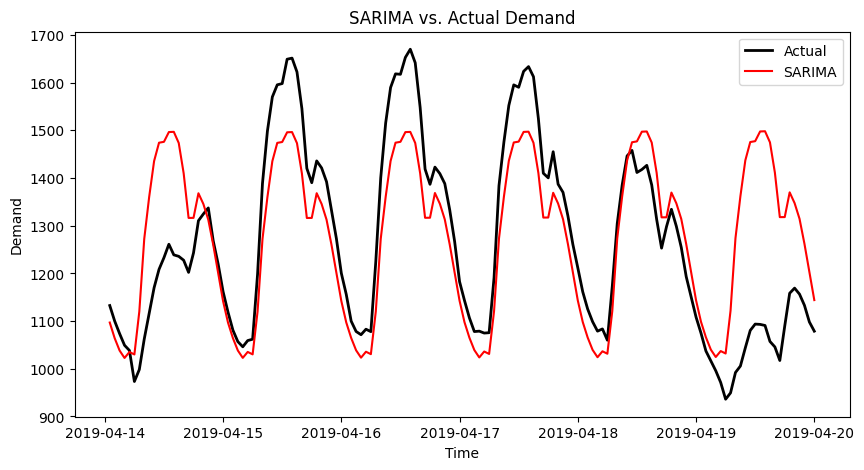

In [16]:

for model_name in ['PyTorchLSTM','KerasLSTM','LR','GB','LightGBM','ARIMA','SARIMA']:
    plt.figure(figsize=(10,5))
    plt.plot(big_results.index, big_results['True'], label='Actual', color='black', linewidth=2)
    plt.plot(big_results.index, big_results[model_name], label=model_name, color='red')
    plt.title(f"{model_name} vs. Actual Demand")
    plt.xlabel("Time")
    plt.ylabel("Demand")
    plt.legend()
    plt.show()



In [17]:

model_performance = {
    'Model': [
        'PyTorch LSTM',
        'Keras LSTM',
        'Linear Regression',
        'Gradient Boosting',
        'LightGBM',
        'ARIMA',
        'SARIMA'
    ],
    'RMSE': [
        pt_rmse,
        k_rmse,
        lr_rmse,
        gb_rmse,
        lgb_rmse,
        arima_rmse,
        sarima_rmse
    ],
    'MAE': [
        pt_mae,
        k_mae,
        lr_mae,
        gb_mae,
        lgb_mae,
        arima_mae,
        sarima_mae
    ],
    'MAPE (%)': [
        pt_mape,
        k_mape,
        lr_mape,
        gb_mape,
        lgb_mape,
        arima_mape,
        sarima_mape
    ]
}


performance_df = pd.DataFrame(model_performance)

# 13. Sort Models by RMSE (Ascending Order: Best to Worst)
performance_df_sorted = performance_df.sort_values(by='RMSE').reset_index(drop=True)

# 14. Display the Sorted Performance Metrics
print("\nModel Performance Sorted by RMSE (Best to Worst):")
print(performance_df_sorted)




Model Performance Sorted by RMSE (Best to Worst):
               Model        RMSE         MAE  MAPE (%)
0       PyTorch LSTM   39.849442   35.641903  0.028599
1           LightGBM   51.085126   43.221209  0.034156
2  Gradient Boosting   53.926055   46.131996  0.036986
3         Keras LSTM   95.202330   82.563852  0.065062
4  Linear Regression  100.260616   58.064864  0.050494
5             SARIMA  134.560711   99.702439  0.081216
6              ARIMA  283.743096  220.314880  0.158442


# Conclusion

From the final comparison, the PyTorch LSTM stands out with the best results, achieving an RMSE of approximately 39.85 and a MAPE of 2.86%, indicating it is highly accurate in capturing the complex patterns of the demand data. Among the other methods, LightGBM and Gradient Boosting also performed relatively well, with RMSEs of around 51.09 and 53.93, respectively. In contrast, classical models such as SARIMA reached an RMSE of 134.56, while ARIMA recorded the highest error of 283.74, reflecting that they struggled to handle more intricate or shifting seasonalities present in the dataset. Similarly, while Keras LSTM did capture sequential information, its RMSE of about 95.20 was significantly higher than the PyTorch LSTM, hinting at potential hyperparameter or structural differences. Ultimately, the results show that PyTorch LSTM is the most promising approach here, followed by advanced tree-based methods; however, the final choice should also consider factors like training time, model interpretability, and the unique characteristics of the dataset at hand.